In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

# import sys
# __file__ = 'full_experiment.ipynb'
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation
from utils.bltools import remove_border, show

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import tensorflow as tf

from config import config_vars

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

### KERAS GPU SETTING
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# # build session running on GPU 1
# configuration = tf.ConfigProto()
# configuration.gpu_options.allow_growth = True
# # configuration.gpu_options.visible_device_list = "0, 1"
# session = tf.Session(config = configuration)

# # apply session
# keras.backend.set_session(session)

Using TensorFlow backend.


In [2]:
config_vars["root_directory"] = 'DATA/FISH/'
experiment_name = '26' ###

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

In [3]:
config_vars["mat_label_dir"] = 'DATA/FISH/raw_annotations/raw_masks/'

In [4]:
valid_list = os.listdir(config_vars["mat_label_dir"])
valid_list = sorted([x for x in valid_list if x.endswith('png')])

list_train = []
list_test = []
list_valid = valid_list

# fd_list = sorted(os.listdir('DATA/LineageTracking/raw_images/'))
# valid_fd_list = fd_list[60:]
# for f in valid_fd_list:
#     tmp_list = os.listdir('DATA/LineageTracking/boundary_labels/' + f)
#     tmp_list = [x for x in tmp_list if x.endswith('png')]
#     for e in sorted(tmp_list):
#         list_valid.append(f + '/' + e)


utils.dirtools.write_path_files(config_vars["path_files_training"], list_train)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_valid)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)

# read txt file into dict partitions with 3 list for train/valid/test
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [ ]:
%%time
# SHOW RESULTS and COMPARISON

compare_dir = config_vars["labels_out_dir"]  ### labels_out_dir  mat_label_dir
all_images = data_partitions["validation"]  

for i, image_name in enumerate(all_images):
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    pred_filename = os.path.join(compare_dir, image_name)
    prediction = skimage.io.imread(pred_filename)

    ground_truth = remove_border(ground_truth)
    prediction = remove_border(prediction)
    
    ground_truth = skimage.morphology.label(ground_truth)
    prediction = skimage.morphology.label(prediction)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)

    show(ground_truth, prediction, image_name=image_name)

(512, 512)


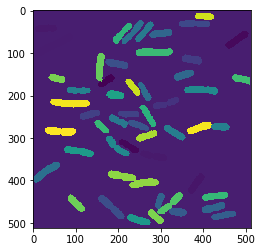

In [41]:
"""
random change labels to show in random colors
"""
def randomize(label):
    u = np.unique(label)
    r = np.arange(166)
    np.random.shuffle(r)
    r = r[:len(u)]

    buffer = np.zeros(label.shape)
    for i in range(len(u)):
        buffer[label == u[i]] = r[i] 
        
    return buffer


ri0 = randomize(i0)
print(ri0.shape)
plt.imshow(ri0)

-----------------------------

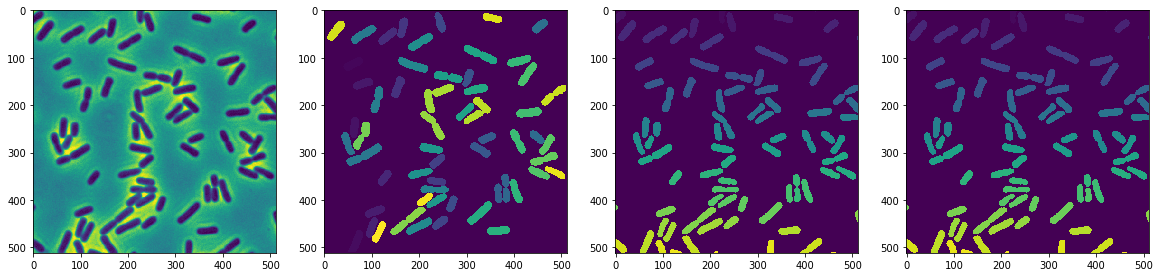

In [50]:
"""
15:binary
16:111
24:1310
22:1315
25:1520
"""

img = '0016.png'

ori = 'DATA/FISH/norm_images/' + img
l0 = 'DATA/FISH/raw_annotations/' + img
ml = 'DATA/FISH/raw_annotations/raw_masks/' + img
l2 = 'DATA/FISH/experiments/15/out/segm/' + img
l3 = 'DATA/FISH/experiments/24/out/segm/' + img
l4 = 'DATA/FISH/experiments/22/out/segm/' + img

ori = skimage.io.imread(ori)
i0 = skimage.io.imread(l0)
i1 = skimage.io.imread(ml)
i2 = skimage.io.imread(l2)
i3 = skimage.io.imread(l3)
i4 = skimage.io.imread(l4)

fig, ax = plt.subplots(1,4,figsize=(20,7))
# ax[0].imshow(i1[100:250, 150:300])
# ax[1].imshow(i2[100:250, 150:300])
# ax[2].imshow(i3[100:250, 150:300])
ax[0].imshow(ori)
ax[1].imshow(i0)
ax[2].imshow(i3)
ax[3].imshow(i4)

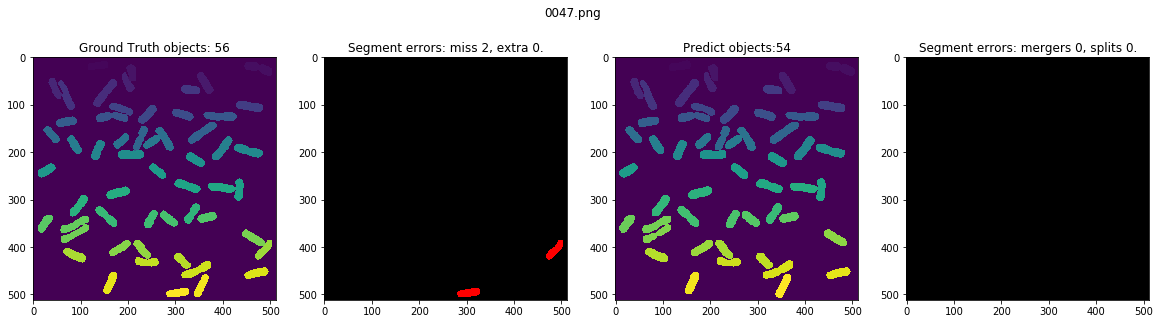

In [8]:
ground_truth = i0  ###
prediction = i4  ###

ground_truth = remove_border(ground_truth)
prediction = remove_border(prediction)
ground_truth = skimage.morphology.label(ground_truth)
prediction = skimage.morphology.label(prediction)
# Apply object dilation
if config_vars["object_dilation"] > 0:
    struct = skimage.morphology.square(config_vars["object_dilation"])
    prediction = skimage.morphology.dilation(prediction, struct)

show(ground_truth, prediction, image_name=image_name)